In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from time import time
from spellchecker import SpellChecker
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:

# Load the dataset
df = pd.read_csv('Restaurant_Reviews 1.tsv', sep='\t')

# Drop missing values
df = df.dropna()

# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

def preprocess_text(text):
    
    if text is None:
        return ""
    
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Correct spelling, filter out non-alphabetic tokens, and lemmatize
    tokens = [spell.correction(token) for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token is not None]
    
    # Return the cleaned text
    return ' '.join(tokens)

# Handle missing values in reviews
df['Review'] = df['Review'].fillna('')  # Replace missing values with empty strings

# Apply preprocessing
df['Cleaned_Review'] = df['Review'].apply(preprocess_text)


In [3]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Review']).toarray()
y = df['Liked']

# Save the vectorizer for future use
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the train-test split data
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(y_train, 'y_train.pkl')


['y_train.pkl']

In [4]:
# Initialize models

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
best_model = None
best_accuracy = 0
best_model_name = ""



# Iterate through each model
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    training_time = time() - start_time
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))  # Print classification report
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Training Time: {training_time:.2f} seconds\n")

      
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'cv_scores': cv_scores,
        'training_time': training_time,
        'model': model
    
    }
    
    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

# Print the best model details
print(f"Best Model: {best_model_name}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")

# Save the best model
joblib.dump(best_model, 'sentiment_model.pkl')
print(f"Best model saved as 'sentiment_model.pkl'.")


Training Naive Bayes...

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77        96
           1       0.79      0.78      0.78       104

    accuracy                           0.78       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200

Naive Bayes Accuracy: 0.7750
Naive Bayes Training Time: 0.01 seconds

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        96
           1       0.83      0.66      0.74       104

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.75       200
weighted avg       0.77      0.76      0.75       200

Logistic Regression Accuracy: 0.7550
Logistic Regression Training Time: 0.02 seconds

Training SVM...

SVM Classification Report:
          


Model Comparison Table:
                 Model  Accuracy  Cross-Validation Mean  \
0          Naive Bayes     0.775                0.77000   
1  Logistic Regression     0.755                0.78250   
2                  SVM     0.780                0.78125   
3        Random Forest     0.740                0.75375   

   Training Time (seconds)  
0                 0.007003  
1                 0.024003  
2                 2.802433  
3                 0.607607  


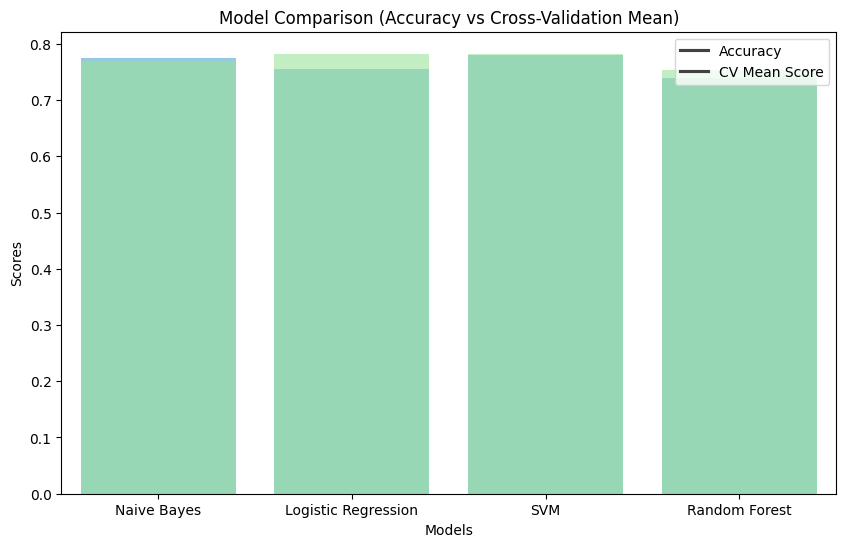

['model_results.pkl']

In [5]:

model_names = list(results.keys())
accuracy_scores = [results[name]['accuracy'] for name in model_names]
cv_mean_scores = [results[name]['cv_scores'].mean() for name in model_names]
training_times = [results[name]['training_time'] for name in model_names]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Cross-Validation Mean': cv_mean_scores,
    'Training Time (seconds)': training_times
})

# Print the table
print("\nModel Comparison Table:")
print(comparison_df)

# Plotting the accuracy and cross-validation mean scores
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, color='skyblue')
sns.barplot(x=model_names, y=cv_mean_scores, color='lightgreen', alpha=0.6)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison (Accuracy vs Cross-Validation Mean)')
plt.legend(["Accuracy", "CV Mean Score"])

# Show the plot
plt.show()

# Save the results for future reference
joblib.dump(results, 'model_results.pkl')
